notebook_deniz_f_selection

1. Variance Thresholder

In [1]:
# X_train, X_test, y_train, y_test = train_test_split(data, target)
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(X_train)

# thresholder = VarianceThreshold(threshold=.5)
# data_var_th = thresholder.fit_transform(scaled_data)

Next looked at was SelectKBest and a similar alternative SelectFromModel - I model these out so that you can choose the correct k from a visual instead of using the sklearn model

notebook_deniz_feature_selection_last

Again looks at SelectKBest. Next is RFE which is very similar to SelectFromModel and again will be modeled manuallys so that visually we can decide on k and then again SelectFromModel.

notebook_sami_GBR

2. Gradient Boosting

This in addition to RandomForest will be used as the two models using in RFE and SelectFromModel analysis

In [2]:
# GBR = GradientBoostingRegressor(learning_rate= 0.1, n_estimators=1500, max_depth=2)
# GBR.fit(x_train, y_train)
# important_cols = x.columns[GBR.feature_importances_ > 0.0]
# values = GBR.feature_importances_[GBR.feature_importances_ > 0.0]

notebook_tova_features2

In [3]:
# feature_importances = sorted(zip(X_train.columns, rf.feature_importances_), reverse=True, key=lambda x: x[1])
# feature_df = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

# plt.figure(figsize=(18,6))
# plt.bar(feature_df.feature[:25], feature_df.importance[:25])
# plt.xticks(rotation=45)
# plt.title('Feature Importances')
# plt.tight_layout();

In [4]:
# train_scores = []
# f1_macro = []
# accuracy = []
# recall = []
# precision = []

# #Going to run the RFClassification on 
# for num_features in range(1,max_num_features):
#     features = list(feature_df.iloc[:num_features, 0].values) + ['SalePrice']
#     data_partial = data.loc[:, features]
#     X_train, X_test, y_train, y_test = get_binned_train_test_split(data_partial)
#     rf = RandomForestClassifier(**best_params)
#     rf.fit(X_train, y_train)
#     y_pred = rf.predict(X_test)
#     f1_macro.append(f1_score(y_test, y_pred, average='macro'))
#     accuracy.append(accuracy_score(y_test, y_pred))
#     recall.append(recall_score(y_test, y_pred, average='macro'))
#     precision.append(precision_score(y_test, y_pred, average='macro'))
#     train_scores.append(rf.score(X_train, y_train))

In [5]:
# plt.figure(figsize=(18,8))
# plt.plot(range(1, max_num_features), train_scores, label='train_score')
# plt.plot(range(1, max_num_features), f1_macro, label='f1_macro')
# plt.plot(range(1, max_num_features), accuracy, label='accuracy')
# plt.plot(range(1, max_num_features), recall, label='recall')
# plt.plot(range(1, max_num_features), precision, label='precision')
# plt.xticks(range(1, max_num_features))
# plt.legend()
# plt.xlabel('Number of features used')
# plt.ylabel('metric score %')

### Ok what now?
The tools we have are: Variance, GBR feature imporances, and RF feature importances.
We need to decide which to use and what the threshold is or what the number of features we want is.

We will do this seperately for Classification (SVM, RFC) and for Regression (lasso, ridge, and RF). 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [7]:
data = pd.read_csv('Numerical_train.csv')

In [8]:
target = data.SalePrice

In [9]:
target_log = np.log(target)

In [10]:
data = data.drop(['SalePrice', 'Unnamed: 0'], axis=1)

#### Variance

getting variance per feature

In [11]:
thresholder = VarianceThreshold()

In [12]:
thresholder.fit(data)

VarianceThreshold(threshold=0.0)

In [13]:
feature_importances_var = sorted(zip(data.columns, thresholder.variances_), reverse=True, key=lambda x: x[1])
feature_df_var = pd.DataFrame(feature_importances_var, columns=['feature', 'importance'])

In [14]:
feature_df_var.head()

,feature,importance
0,LotArea,9.962523e+07
1,GrLivArea,2.761195e+05
2,MiscVal,2.461368e+05
3,BsmtFinSF1,2.078905e+05
4,BsmtUnfSF,1.952234e+05


In [15]:
feature_df_var.tail()

,feature,importance
151,Exterior2nd_Other,0.000685
152,Exterior1st_AsphShn,0.000685
153,Exterior1st_ImStucc,0.000685
154,Exterior1st_CBlock,0.000685
155,Exterior2nd_CBlock,0.000685


#### GBR

Now getting feature importances from GBR

First lets decide the best parameters

In [16]:
GBR = GradientBoostingRegressor()

In [17]:
param_grid = dict(learning_rate = [1, .1, .001, .0001],
                  n_estimators = [100, 500, 1000, 1500],
                  max_depth = [1, 2, 5, 10])

In [18]:
gridsearch_gbr = GridSearchCV(estimator = GBR, param_grid = param_grid, cv=3)

In [19]:
# gridsearch_gbr.fit(data, target_log)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                

In [20]:
# gridsearch_gbr.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}

In [21]:
best_params_gbr = {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}

Ok, now that we got the best parameters lets find feature importances.

In [22]:
GBR = GradientBoostingRegressor(**best_params_gbr)

In [23]:
GBR.fit(data, target_log)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
feature_importances_gbr = sorted(zip(data.columns, GBR.feature_importances_), reverse=True, key=lambda x: x[1])
feature_df_gbr = pd.DataFrame(feature_importances_gbr, columns=['feature', 'importance'])

In [25]:
feature_df_gbr.head()

,feature,importance
0,OverallQual,0.379858
1,GrLivArea,0.179991
2,TotalBsmtSF,0.064452
3,GarageArea,0.038891
4,KitchenQual,0.037775


In [26]:
feature_df_gbr.tail()

,feature,importance
151,SaleType_CWD,0.0
152,SaleType_Con,0.0
153,SaleType_ConLI,0.0
154,SaleType_ConLw,0.0
155,SaleType_WD,0.0


#### RF

Now getting feature importances from RF

First lets decide the best parameters

In [27]:
# from deniz's GridSearchCV
best_params_rf={'max_depth': 50,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 300}

In [28]:
RF = RandomForestRegressor()

In [29]:
param_grid = dict(max_depth = [35, 40, 45],
                  min_samples_leaf = [1, 2, 3],
                  min_samples_split = [3, 4, 5],
                  n_estimators = [250, 300, 350, 400, 450])

In [30]:
gridsearch_rf = GridSearchCV(estimator = RF, param_grid = param_grid, cv=3)

In [31]:
# gridsearch_rf.fit(data, target_log)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [35, 40, 45],
    

In [33]:
# gridsearch_rf.best_params_

{'max_depth': 35,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 250}

In [34]:
best_params_rf = {'max_depth': 35,
                  'min_samples_leaf': 2,
                  'min_samples_split': 4,
                  'n_estimators': 250}

Ok, now that we got the best parameters lets find feature importances.

In [35]:
RF = RandomForestRegressor(**best_params_rf)

In [36]:
RF.fit(data, target_log)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=250,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [37]:
feature_importances_rf = sorted(zip(data.columns, RF.feature_importances_), reverse=True, key=lambda x: x[1])
feature_df_rf = pd.DataFrame(feature_importances_rf, columns=['feature', 'importance'])

In [38]:
feature_df_rf.head()

,feature,importance
0,OverallQual,0.566927
1,GrLivArea,0.115816
2,TotalBsmtSF,0.048606
3,GarageArea,0.040706
4,1stFlrSF,0.023441


In [39]:
feature_df_rf.tail()

,feature,importance
151,SaleType_CWD,0.0
152,SaleType_Con,0.0
153,SaleType_ConLI,0.0
154,SaleType_ConLw,0.0
155,SaleType_Oth,0.0


#### ok so now we have 3 lists of feature importances: variance, gbr, and rf

now lets compare then and see the overlap

In [40]:
features_compare = pd.DataFrame()

In [41]:
features_compare['var'] = feature_df_var.feature
features_compare['gbr'] = feature_df_gbr.feature
features_compare['rf'] = feature_df_rf.feature

In [42]:
features_compare.head(10)

,var,gbr,rf
0,LotArea,OverallQual,OverallQual
1,GrLivArea,GrLivArea,GrLivArea
2,MiscVal,TotalBsmtSF,TotalBsmtSF
3,BsmtFinSF1,GarageArea,GarageArea
4,BsmtUnfSF,KitchenQual,1stFlrSF
5,TotalBsmtSF,ExterQual,BsmtFinSF1
6,2ndFlrSF,GarageFinish,YearBuilt
7,1stFlrSF,LotArea,CentralAir
8,GarageArea,BsmtFinSF1,LotArea
9,MasVnrArea,YearBuilt,OverallCond


In [43]:
def top_n_features(n):
    return features_compare.iloc[:n, :].stack().value_counts()

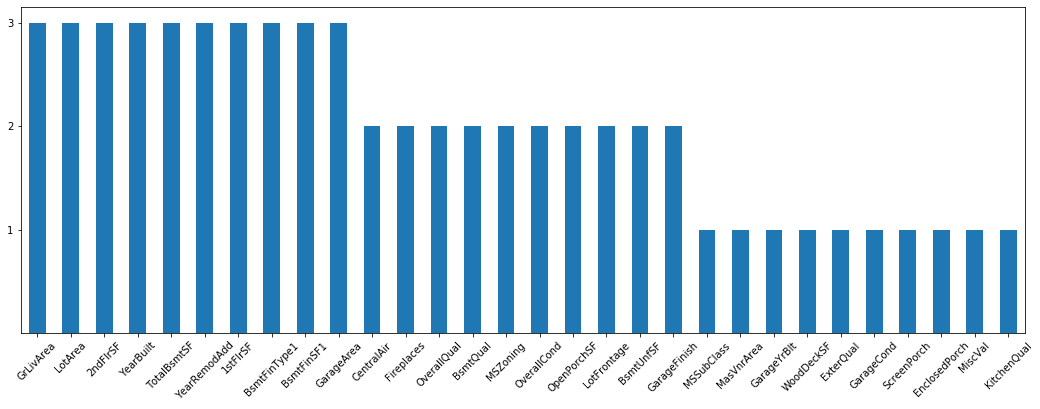

In [44]:
plt.figure(figsize=(18,6))
top_n_features(20)[:40].plot(kind='bar')
plt.xticks(rotation=45);
plt.yticks([1,2,3]);

In [48]:
top_n = top_n_features(20)

You can see from here the features that all, two, and at least one model thinks are the top 20 in importance

### Now for each of the models we will do some feature selection and then compare the best of each models

#### Lasso

In [49]:
max_num_features = 51

In [50]:
lasso_train_scores = pd.DataFrame()
lasso_test_scores = pd.DataFrame()

In [51]:
for name, feature_df in zip(['var', 'gbr', 'rf'], [feature_df_var, feature_df_gbr, feature_df_rf]):
    lasso_r_squared_train = []
    lasso_r_squared_test = []
    
    for num_features in range(1,max_num_features):
        features = list(feature_df.iloc[:num_features, 0].values)
        data_partial = data.loc[:, features]
        
        pipeline_lasso = Pipeline([('scaler', StandardScaler()), ('estimator', Lasso(alpha=.0005))])
        scores = cross_validate(pipeline_lasso, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)
        
        lasso_r_squared_train.append(scores['train_score'].mean())
        lasso_r_squared_test.append(scores['test_score'].mean())
    
    lasso_train_scores[name] = lasso_r_squared_train
    lasso_test_scores[name] = lasso_r_squared_test

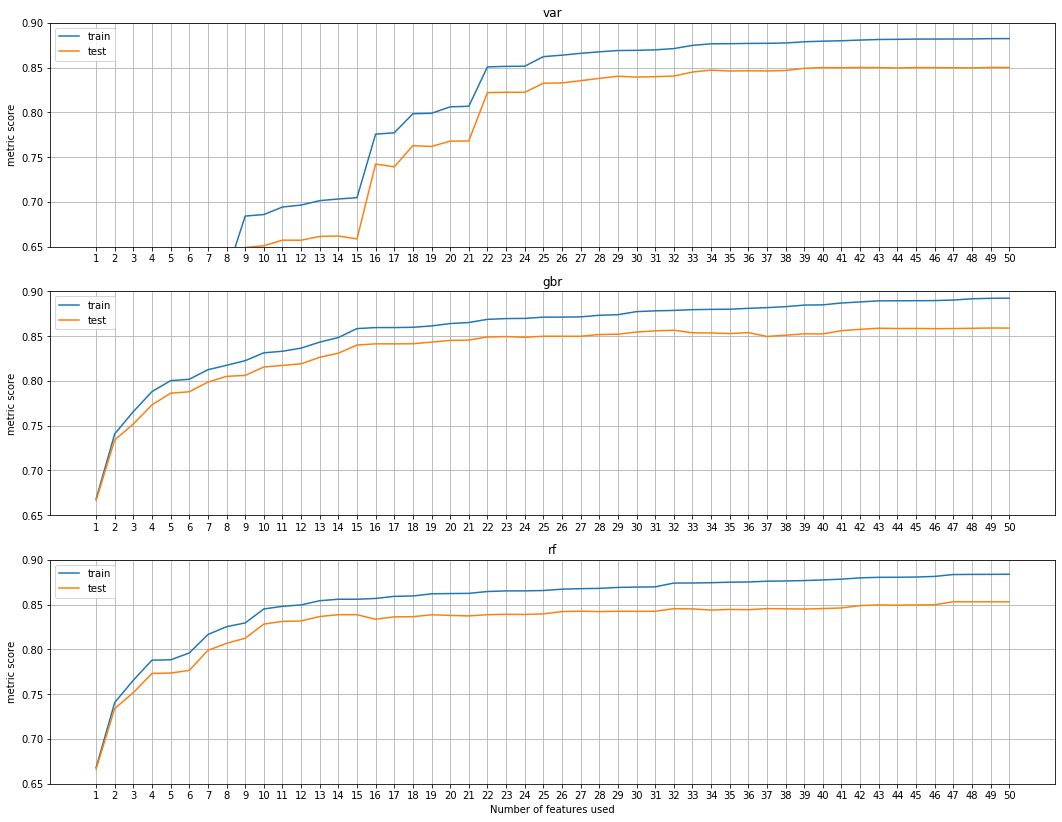

In [52]:
fig, axes = plt.subplots(3,1, figsize=(18,14))

for ax, name in zip([0,1,2], ['var', 'gbr', 'rf']):
    axes[ax].plot(range(1, max_num_features), lasso_train_scores[name], label='train')
    axes[ax].plot(range(1, max_num_features), lasso_test_scores[name], label='test')
    axes[ax].legend()
    axes[ax].set_ylabel('metric score')
    axes[ax].title.set_text(name)
    axes[ax].set_xticks(range(1, max_num_features))
    axes[ax].grid()
    axes[ax].set_ylim(.65,.9)
    
plt.xlabel('Number of features used');

In [53]:
cross_validate(pipeline, data, target_log, cv=3, scoring='r2', return_train_score=True)
print('Compare to scores on full data')
print('train score,' , scores['train_score'].mean())
print('test score,' , scores['test_score'].mean())

Compare to scores on full data
train score, 0.8840650222449806
test score, 0.8531724373718932


#### Ridge

In [54]:
max_num_features = 51

In [55]:
ridge_train_scores = pd.DataFrame()
ridge_test_scores = pd.DataFrame()

In [56]:
for name, feature_df in zip(['var', 'gbr', 'rf'], [feature_df_var, feature_df_gbr, feature_df_rf]):
    ridge_r_squared_train = []
    ridge_r_squared_test = []
    
    for num_features in range(1,max_num_features):
        features = list(feature_df.iloc[:num_features, 0].values)
        data_partial = data.loc[:, features]
        
        pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('estimator', Ridge(alpha=5))])
        scores = cross_validate(pipeline_ridge, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)
        
        ridge_r_squared_train.append(scores['train_score'].mean())
        ridge_r_squared_test.append(scores['test_score'].mean())
    
    ridge_train_scores[name] = ridge_r_squared_train
    ridge_test_scores[name] = ridge_r_squared_test

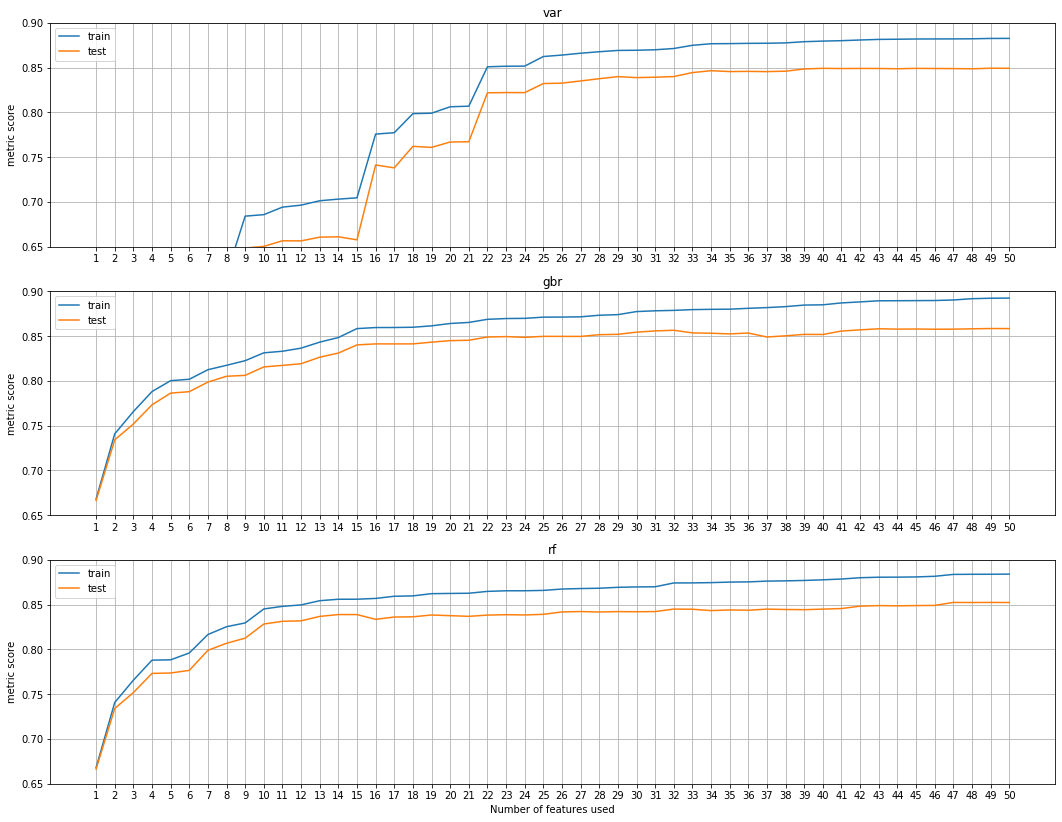

In [57]:
fig, axes = plt.subplots(3,1, figsize=(18,14))

for ax, name in zip([0,1,2], ['var', 'gbr', 'rf']):
    axes[ax].plot(range(1, max_num_features), ridge_train_scores[name], label='train')
    axes[ax].plot(range(1, max_num_features), ridge_test_scores[name], label='test')
    axes[ax].legend()
    axes[ax].set_ylabel('metric score')
    axes[ax].title.set_text(name)
    axes[ax].set_xticks(range(1, max_num_features))
    axes[ax].grid()
    axes[ax].set_ylim(.65,.9)
    
plt.xlabel('Number of features used');

In [58]:
cross_validate(pipeline, data, target_log, cv=3, scoring='r2', return_train_score=True)
print('Compare to scores on full data')
print('train score,' , scores['train_score'].mean())
print('test score,' , scores['test_score'].mean())

Compare to scores on full data
train score, 0.8842033509243098
test score, 0.8524567526069616


#### Random Forest

In [59]:
max_num_features = 31

In [60]:
rf_train_scores = pd.DataFrame()
rf_test_scores = pd.DataFrame()

In [61]:
for name, feature_df in zip(['var', 'gbr', 'rf'], [feature_df_var, feature_df_gbr, feature_df_rf]):
    rf_r_squared_train = []
    rf_r_squared_test = []
    
    for num_features in range(1,max_num_features):
        features = list(feature_df.iloc[:num_features, 0].values)
        data_partial = data.loc[:, features]
        
        rf = RandomForestRegressor(**best_params_rf)
        scores = cross_validate(rf, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)
        
        rf_r_squared_train.append(scores['train_score'].mean())
        rf_r_squared_test.append(scores['test_score'].mean())
    
    rf_train_scores[name] = rf_r_squared_train
    rf_test_scores[name] = rf_r_squared_test

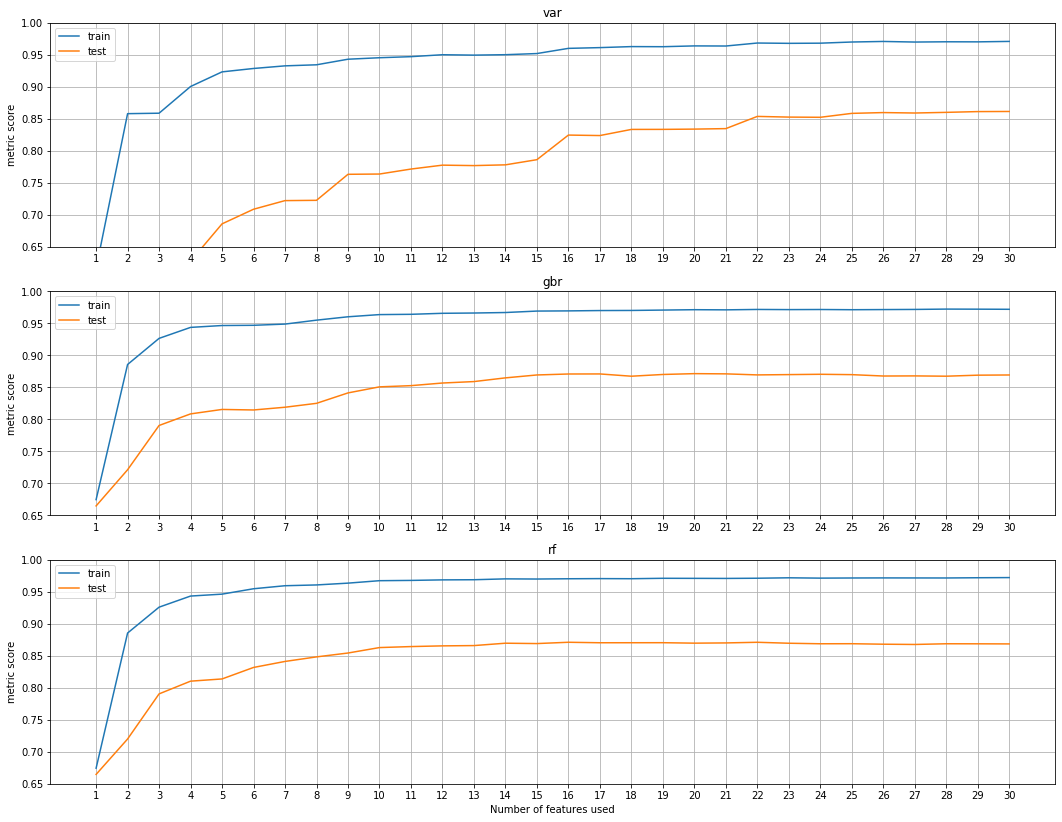

In [62]:
fig, axes = plt.subplots(3,1, figsize=(18,14))

for ax, name in zip([0,1,2], ['var', 'gbr', 'rf']):
    axes[ax].plot(range(1, max_num_features), rf_train_scores[name], label='train')
    axes[ax].plot(range(1, max_num_features), rf_test_scores[name], label='test')
    axes[ax].legend()
    axes[ax].set_ylabel('metric score')
    axes[ax].title.set_text(name)
    axes[ax].set_xticks(range(1, max_num_features))
    axes[ax].grid()
    axes[ax].set_ylim(.65,1)
    
plt.xlabel('Number of features used');

In [ ]:
cross_validate(rf, data, target_log, cv=3, scoring='r2', return_train_score=True)
print('Compare to scores on full data')
print('train score,' , scores['train_score'].mean())
print('test score,' , scores['test_score'].mean())

### Comparing features

#### set of top 10

top_10 is the set of all features that falls into the top 10 features of any of the feature rating technique

In [107]:
top_10 = top_n_features(10).index

In [108]:
data_partial = data.loc[:, top_10]

In [109]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()), ('estimator', Lasso(alpha=.0005))])
scores_lasso = cross_validate(pipeline_lasso, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('estimator', Ridge(alpha=5))])
scores_ridge = cross_validate(pipeline_ridge, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)
    
rf = RandomForestRegressor(**best_params_rf)
scores_rf = cross_validate(rf, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

for model, scores in zip(['lasso', 'ridge', 'rf'], [scores_lasso, scores_ridge, scores_rf]):
        print(model, 'train: ', scores['train_score'].mean())
        print(model, 'test: ', scores['test_score'].mean())

lasso train:  0.8524974346635332
lasso test:  0.8357069880251761
ridge train:  0.852610265839897
ridge test:  0.8357030260639359
rf train:  0.9690390954720359
rf test:  0.8654113281900968


In [110]:
len(top_10)

17

In [111]:
top_10

Index(['GrLivArea', 'BsmtFinSF1', 'LotArea', 'GarageArea', 'TotalBsmtSF',
       'YearBuilt', 'OverallQual', '1stFlrSF', 'CentralAir', 'ExterQual',
       '2ndFlrSF', 'BsmtUnfSF', 'MasVnrArea', 'MiscVal', 'GarageFinish',
       'OverallCond', 'KitchenQual'],
      dtype='object')

##### For random forest these are enough to achieve optimum results.

#### set of top 20

In [113]:
top_20 = top_n_features(20).index

top_20 is the set of all features that falls into the top 20 features of any of the feature rating technique

In [114]:
data_partial = data.loc[:, top_20]

In [115]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()), ('estimator', Lasso(alpha=.0005))])
scores_lasso = cross_validate(pipeline_lasso, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('estimator', Ridge(alpha=5))])
scores_ridge = cross_validate(pipeline_ridge, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)
    
rf = RandomForestRegressor(**best_params_rf)
scores_rf = cross_validate(rf, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

for model, scores in zip(['lasso', 'ridge', 'rf'], [scores_lasso, scores_ridge, scores_rf]):
        print(model, 'train: ', scores['train_score'].mean())
        print(model, 'test: ', scores['test_score'].mean())

lasso train:  0.87207095107608
lasso test:  0.8442400710037963
ridge train:  0.8721523140560872
ridge test:  0.8436000933808435
rf train:  0.9719560628027578
rf test:  0.8685787491457869


In [116]:
len(top_20)

30

#### set of top 30

In [117]:
top_30 = top_n_features(30).index

top_30 is the set of all features that falls into the top 30 features of any of the feature rating technique

In [118]:
data_partial = data.loc[:, top_30]

In [119]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()), ('estimator', Lasso(alpha=.0005))])
scores_lasso = cross_validate(pipeline_lasso, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('estimator', Ridge(alpha=5))])
scores_ridge = cross_validate(pipeline_ridge, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)
    
rf = RandomForestRegressor(**best_params_rf)
scores_rf = cross_validate(rf, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

for model, scores in zip(['lasso', 'ridge', 'rf'], [scores_lasso, scores_ridge, scores_rf]):
        print(model, 'train: ', scores['train_score'].mean())
        print(model, 'test: ', scores['test_score'].mean())

lasso train:  0.8872659153423627
lasso test:  0.8557495327184231
ridge train:  0.8873415940733475
ridge test:  0.8552451777135993
rf train:  0.9726529923288805
rf test:  0.8679829363748507


In [120]:
len(top_30)

44

#### set of top 40

In [121]:
top_40 = top_n_features(40).index

top_40 is the set of all features that falls into the top 40 features of any of the feature rating technique

In [122]:
data_partial = data.loc[:, top_40]

In [123]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()), ('estimator', Lasso(alpha=.0005))])
scores_lasso = cross_validate(pipeline_lasso, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('estimator', Ridge(alpha=5))])
scores_ridge = cross_validate(pipeline_ridge, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)
    
rf = RandomForestRegressor(**best_params_rf)
scores_rf = cross_validate(rf, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

for model, scores in zip(['lasso', 'ridge', 'rf'], [scores_lasso, scores_ridge, scores_rf]):
        print(model, 'train: ', scores['train_score'].mean())
        print(model, 'test: ', scores['test_score'].mean())

lasso train:  0.8955802717650778
lasso test:  0.8596436699040152
ridge train:  0.8956724920415274
ridge test:  0.8588616293315336
rf train:  0.9724606057370374
rf test:  0.8671150214573453


In [124]:
len(top_40)

54

#### set of top 50

In [125]:
top_50 = top_n_features(50).index

top_50 is the set of all features that falls into the top 50 features of any of the feature rating technique

In [126]:
data_partial = data.loc[:, top_50]

In [127]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()), ('estimator', Lasso(alpha=.0005))])
scores_lasso = cross_validate(pipeline_lasso, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('estimator', Ridge(alpha=5))])
scores_ridge = cross_validate(pipeline_ridge, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)
    
rf = RandomForestRegressor(**best_params_rf)
scores_rf = cross_validate(rf, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

for model, scores in zip(['lasso', 'ridge', 'rf'], [scores_lasso, scores_ridge, scores_rf]):
        print(model, 'train: ', scores['train_score'].mean())
        print(model, 'test: ', scores['test_score'].mean())

lasso train:  0.9009899204443611
lasso test:  0.861223973618875
ridge train:  0.9012755170941998
ridge test:  0.8600878719523153
rf train:  0.9729020977838642
rf test:  0.867648013654439


In [128]:
len(top_50)

71